### [0] Introduction:
This is a practice exercise using TensorFlow to solve an Ordinary Least Squares Regression via. a simple Neural Network. The purpose here is to gain familiarity with TensorFlow's computational graph framework. We will follow an artificially generated toy example and compare results from the Neural Network to those of sckikit-learn's out of box `sklearn.linear_model.LinearRegression` model.

### [1] Data Generation:
We begin by generating random sample ($n=500$) of data following the linear relationship 

$$y = \beta_0 + \beta_1x  + \epsilon,$$ 

with arbitrarily selected parameters $\beta_0 = 10, \beta_1 = 2$ and $\epsilon \sim  \mathcal{N}(0,10^2)$. Moreover, we set the domain of the dependent variable to be $\mathbb{N} \cap [1,100]$:

In [216]:
import numpy as np

np.random.seed(888)

n = 500
x = np.random.randint(1,100, n)
y = 10 + 2*x + 10*np.random.randn(n)

# reshape and set precision for modelling
x = x.reshape(n, 1).astype(np.float64)
y = y.reshape(n, 1).astype(np.float64)

### [2] `sklearn` Model:
We begin by generating random sample ($n=500$) of data following the linear relationship 

$$y = \beta_0 + \beta_1x  + \epsilon,$$ 

with arbitrarily selected parameters $\beta_0 = 10, \beta_1 = 2$ and $\epsilon \sim  \mathcal{N}(0,10^2)$. Moreover, we set the domain of the dependent variable to be $\mathbb{N} \cap [1,100]$:

beta_0: 11.826724863127168
beta_1: 1.982784526230367


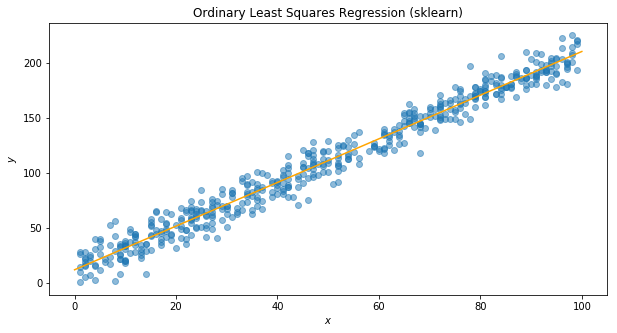

In [252]:
import sklearn as sk
import matplotlib.pyplot as plt

# fit sk linear regression 
reg    = sk.linear_model.LinearRegression().fit(x, y)
beta_1 = reg.coef_
beta_0 = reg.intercept_

# line of best fit 
z = np.linspace(0, 100, 2)
w = beta_1[0]*z + beta_0[0]

# plot 
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(x, y, alpha=0.5)
ax.plot(z, w, color="orange")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Ordinary Least Squares Regression (sklearn)")

print("beta_0: {}".format(beta_0[0]))
print("beta_1: {}".format(beta_1[0][0]))

### [3] `tensorflow` Model:
foobar

In [271]:
w = []

training_steps = 50000
learning_rate  = 0.000001
bias_with_x = np.array([(1., a) for a in x]).astype(np.float64)
target      = y.astype(np.float64)
weights     = np.array([0, 0]).astype(np.float64).reshape(2,1)

for i in range(training_steps):
    w.append(weights.flatten())
    y_hat = np.matmul(bias_with_x, weights)
    y_err = target - y_hat
    grad  = np.matmul(bias_with_x.T,  y_err)
    weights = weights + learning_rate*grad